# Linear programming tools and demonstrations
By <a href="https://www.maxkapur.com/">Max Kapur</a>. Updated Mar. 24, 2020.

In [1]:
import numpy as np
import sympy as sp
sp.init_printing()
import networkx as nx
import scipy.optimize as optimize
import matplotlib as mpl
import matplotlib.pyplot as plt

## Pivoting a system of linear equations in Sympy
Reference: Robert J. Vanderbei, *Linear Programming: Foundations and Extensions,* ch. 2.

In [27]:
def dict_helper(c, A, b):
    # Create vectors of variables (x) and slack variables (w)
    x = sp.MatrixSymbol('x', len(c),1)
    w = sp.MatrixSymbol('w', len(b),1)
    # Return the objective function and constraint functions as a dictionary compatible with 
    return x, w, {'obj': c.T * x, 'con': sp.Eq(w, b - (A*x))}

# Returns the above dictionary pivoted with the given x_i or w_j values as the basis.
def pivot(seed_dict, basic):
    assert len(basic) == seed_dict['con'].lhs.shape[0], "Number of variables in basis must equal number of constraints ({})".format(seed_dict['con'].lhs.shape[0])
    con_as_mutable = sp.Eq(seed_dict['con'].lhs.as_mutable(), seed_dict['con'].rhs.as_mutable())
    constraints = sp.solve(con_as_mutable, basic)
    return{# Objective function
           'obj': sp.Matrix(seed_dict['obj']).subs(constraints).expand(),
           # New constraint functions
           'con': sp.Eq(sp.Matrix(list(constraints.keys())), sp.Matrix(list(constraints.values())))} 

In [3]:
# pivot() is compatible with its own output, so you can chain like so:
# pivot( pivot(seed_dict, (x[1], w[0])), (x[1], x[2]))['con']

In [4]:
## A few pitfalls (will return errors):

# Need to choose the right number of basic variables
# pivot(seed_dict, (x[1], x[2], x[0]))['con']

# x1 and x2 are used as symbols but not defined as variables
# pivot(seed_dict, (x1, x2))['con']

#### Example

Rewritten in matrix form and indicing from 0, problem 2.3 has us maximize

$$\zeta =  2x_0 - 6x_1 $$

subject to 

$$\begin{align}
\begin{bmatrix} -1 & -1 & -1 \\
2 & -1 & 1\\ \end{bmatrix} x &\leq \begin{bmatrix} -2 \\ 1 \end{bmatrix} \\ \\
x &\geq 0\end{align}$$

(The vector $x$ is of length 3.)

Since both $c$ and $b$ contain a mix of positive and negative values, the starting dictionary is neither primal nor dual feasible; we need to use a Phase I algorithm to generate a feasible starting dictionary.

In [5]:
c = sp.Matrix([2, -6,0])
A = sp.Matrix([[1, 1, 1],[-2, 1, -1]])*-1
b = sp.Matrix([-2, 1])

x, w, seed_dict = dict_helper(c, A, b)
x, w

In [6]:
seed_dict['obj']

[2  -6  0]⋅x

In [7]:
seed_dict['con']

    ⎡1   1  1 ⎤     ⎡-2⎤
w = ⎢         ⎥⋅x + ⎢  ⎥
    ⎣-2  1  -1⎦     ⎣1 ⎦

I happen to know that the optimal solution has $x_1$ and $x_2$ basic, but in the simplex method we would swap variables into the basis one at a time according to the set of pivoting rules chosen.

In [8]:
pivot(seed_dict, (x[1], x[2]))['obj']

[-3⋅w₀₀ - 3⋅w₁₀ - x₀₀ - 3]

In [9]:
pivot(seed_dict, (x[1], x[2]))['con']

        ⎡ w₀₀   w₁₀   x₀₀   1 ⎤
        ⎢ ─── + ─── + ─── + ─ ⎥
⎡x₁₀⎤   ⎢  2     2     2    2 ⎥
⎢   ⎥ = ⎢                     ⎥
⎣x₂₀⎦   ⎢w₀₀   w₁₀   3⋅x₀₀   3⎥
        ⎢─── - ─── - ───── + ─⎥
        ⎣ 2     2      2     2⎦

Note that the constant terms in $x_1$ and $x_2$ are positive, while the cost coefficients in the current dictionary&rsquo;s objective function are all negative. That implies that this dictionary is optimal, with $x = (0, 1/2, 3/2)$ and $\zeta = -3$.

## Upper and lower bounds for a worst-case simplex problem
Reference: Robert J. Vanderbei, *Linear Programming: Foundations and Extensions,* ch. 4.

Problem 9 asks, 
> Show that, for any integer *n,*
> $$\frac{1}{2n} 2^{2n} \leq \binom{2n}{n} \leq 2^{2n}$$

These are tighter bounds than those <a href="https://math.stackexchange.com/questions/1352338/proof-for-the-upper-bound-and-lower-bound-for-binomial-coefficients">commonly given for the binomial coefficient</a>, so the proof is worthwhile.
    
We have 

$$\begin{align}
\binom{2n}{n} = \frac{(2n)!}{n!\,n!} = \left(\frac{2n}{n}\right)\left(\frac{2n-1}{n}\right)\left(\frac{2n-2}{n-1}\right)\left(\frac{2n-3}{n-1} \right)\left(\frac{2n-4}{n-2}\right)\left(\frac{2n-5}{n-2}\right)\biggl(\frac{\quad\cdots\quad}{\cdots}\biggr)\left(\frac{2}{1}\right)\left(\frac{1}{1}\right)
\end{align}$$

On the right, where I have spliced together the $n!$s in the denominator, note that for the $n$ &ldquo;even&rdquo; terms, 

$$\begin{align}
\left\lbrace\frac{2n}{n},  \frac{2n-2}{n-1}, \frac{2n-4}{n-2},  \cdots,  \frac{2}{1}\right\rbrace = 2
\end{align}$$

while for the $n$ &ldquo;odd&rdquo; terms, 

$$\begin{align}
\left\lbrace\frac{2n-1}{n} ,  \frac{2n-3}{n-1}, \frac{2n-5}{n-2} , \cdots , \frac{1}{1}\right\rbrace  \leq 2
\end{align}$$

Thus, the entire expression has

$$\begin{align}
\binom{2n}{n} \leq (2)(2) \cdots (2)(2) = 2^{2n}
\end{align}$$

and the upper bound is established.

For the lower bound, it suffices to show that $ \binom{2n}{n}\left(2n\right) \geq  2^{2n} $. We have


$$\begin{align}
\binom{2n}{n}\left(2n\right) &= \frac{(2n)!}{n!\,n!} \left(2n\right) \\
&= \left(\frac{2n}{n}\right)\left(\frac{2n-1}{n}\right)\left(\frac{2n-2}{n-1}\right)\left(\frac{2n-3}{n-1} \right)\left(\frac{2n-4}{n-2}\right)\left(\frac{2n-5}{n-2}\right)\biggl(\frac{\quad\cdots\quad}{\cdots}\biggr)\left(\frac{2}{1}\right)\left(\frac{1}{1}\right) \left(2n\right)\\
&= \Biggl[\left(\frac{2n}{n}\right)\left(\frac{2n-2}{n-1}\right)\left(\frac{2n-4}{n-2}\right)\biggl(\frac{\quad\cdots\quad}{\cdots}\biggr)\left(\frac{2}{1}\right)\Biggr]
\Biggl[\left(\frac{2n-1}{n}\right)\left(\frac{2n-3}{n-1}\right)\left(\frac{2n-5}{n-2}\right)\biggl(\frac{\quad\cdots\quad}{\cdots}\biggr)\left(\frac{1}{1}\right)\Biggr]  \left(2n\right)\\
\end{align}$$

The first group equals $2^n$. Now pull $2n$ inside the second group and nudge each numerator over to the right. Then increase all but the first of the denominators in the second group by $1/2$ (which decreases the value of the expression) and factor $2$ out of the numerators:

$$\begin{align}
\binom{2n}{n}\left(2n\right) &= \Biggl[\;2^n\;\Biggr]
\Biggl[\left(\frac{2n}{n}\right)\left(\frac{2n-1}{n-1}\right)\left(\frac{2n-3}{n-2}\right)\biggl(\frac{\quad\cdots\quad}{\cdots}\biggr)\left(\frac{3}{1}\right)\Biggr] \\
&\geq \Biggl[\;2^n\;\Biggr]
\Biggl[\left(\frac{2n}{n}\right)\left(\frac{2\left(n-\frac{1}{2}\right)}{n-\frac{1}{2}}\right)\left(\frac{2\left(n-\frac{3}{2}\right)}{n-\frac{3}{2}}\right)\biggl(\frac{\quad\cdots\quad}{\cdots}\biggr)\left(\frac{3}{\frac{3}{2}}\right)\Biggr] = 2^n \cdot 2^n = 2^{2n} \\
\end{align}$$

This establishes the lower bound.

## The self-dual simplex method
Reference: Robert J. Vanderbei, *Linear Programming: Foundations and Extensions,* ch. 7.

In the self-dual simplex method, given an infeasible and/or inoptimal starting dictionary, we subtract $\mu \bar z_\mathcal{N}$ from each of the terms in $c$ and add $\mu \bar x_\mathcal{B}$ to each of the terms in $b$. $\bar z_\mathcal{N}$ and $\bar x_\mathcal{B}$ are vectors of arbitrary positive constants. Then, for some positive minimal value of $\mu$, the dictionary is dual feasible. We pivot (it may be a dual or primal pivot) around the variable whose coefficient provides that minimum to yield a new dictionary which is dual feasible with some lower minimum for $\mu$. Keep iterating until that minumum dips below 0; then setting $\mu =0$ yields the optimal dictionary for the original problem.

I solve problem 2.3, shown above, using my pivot tool and the self-dual simplex method.  

In [10]:
def dict_helper_selfdual(c, A, b):
    x = sp.MatrixSymbol('x', len(c),1)
    w = sp.MatrixSymbol('w', len(b),1)
    X = sp.Matrix([sp.Matrix(i) for i in [x, w]]) # Useful for formatting
    
    mu = sp.symbols('mu')

    # Update c and b with mu perturbations
    # As the text suggests, coefs of mu drawn from continuous interval (0.5, 1.5)
    c -= sp.Matrix((np.random.rand(len(c))+0.5))*mu
    b += sp.Matrix((np.random.rand(len(b))+0.5))*mu

    # Uses 1 as mu coefs; creates degenerate pivots
    # c -= sp.Matrix([1]*len(c))*mu
    # b += sp.Matrix([1]*len(b))*mu

    seed_dict = {'obj': sp.Matrix(c.T * x),
                 'con': sp.Eq(sp.Matrix(w), sp.Matrix(b - A*x))}
    
    return x, w, X, mu, seed_dict

In [11]:
# Function that picks apart a dictionary and discovers bounds on mu
def discover_bounds(seed_dict):
    # Initialize bounds dictionaries
    lb = {}
    ub = {}
    
    # Bounds on mu from basic equations
    check = [[k, 
              i.as_coefficients_dict()[mu],
              i.as_coefficients_dict()[1]] for i, k in zip(sp.Matrix(seed_dict['con'].rhs),sp.Matrix(seed_dict['con'].lhs))]
    for v, x, b in check: 
        if sp.sign(x) == -1:
            ub[v] =  -b/x
        if sp.sign(x) ==  1:     # if x == 0 do nothing
            lb[v] =  -b/x
        
    # Constraints on mu from coeffs in objective function
    nbvars = X[[i not in seed_dict['con'].lhs for i in X],:]
    check2 = [[i,
               sp.Matrix(seed_dict['obj'])[0].coeff(i).coeff(mu),
               sp.Matrix(seed_dict['obj'])[0].coeff(i).subs(mu,0)] for i in nbvars]
    for v, z, c in check2: 
        if sp.sign(z) == -1:
            lb[v] = -c/z
        if sp.sign(z) ==  1:     # if z == 0 do nothing
            ub[v] = -c/z
    return lb, ub

In [12]:
# Given the output of the previous function, find the tightest bounds
# and indicate which variable they came from. Returns only the mu-value
# for the lower bound, which we will use in the ratio test.
def get_bounds(seed_dict):
    lb, ub = discover_bounds(seed_dict)
    if lb == {}: lower = -sp.oo
    if lb != {}: lower = max(lb.values())
    if ub == {}: upper = sp.oo
    if ub != {}: upper = min(ub.values())
    if upper < lower:
        raise Warning('Bad pivot; problem may be unbounded or infeasible')
    print('Lower bound: {}\nUpper bound: {}\nVariable to swap: {}'.format(lower, upper, max(lb, key = lb.get)))
    return max(lb, key = lb.get), lower

In [13]:
def primal_rt(seed_dict, var, test_mu):
    ratios = {k:-i.coeff(var)
               / (i.subs({j: 0 for j in X}).subs(mu, test_mu))
              for i,k in zip(seed_dict['con'].rhs, seed_dict['con'].lhs)}
    print('Leaving variable: {}'.format(max(ratios, key = ratios.get)))
    print(ratios)
    return max(ratios, key = ratios.get)

In [14]:
def dual_rt(seed_dict, var, test_mu):
    # Identify the working row
    where = np.where([var==i for i in seed_dict['con'].lhs])[0][0]
    # Identify the nonbasic variables
    nbvars = X[[i not in seed_dict['con'].lhs for i in X],:]
    ratios = {j: (-seed_dict['con'].rhs[where].coeff(j)
                  / (seed_dict['obj'][0].coeff(j)).subs(mu, test_mu)) for j in nbvars}
    print('Entering variable: {}'.format(max(ratios, key = ratios.get)))
    print(ratios)
    return max(ratios, key = ratios.get)

In [15]:
def selfdual_wizard(seed_dict):
    # Current bounds on mu
    v, t = get_bounds(seed_dict)
    
    # Optimality if lower bound below zero
    if t <= 0:
        print('Optimal dictionary')
        zeta = seed_dict['obj'][0].subs(mu,0).subs({j:0 for j in X})
        nbvals = {a:b for a, b in zip(seed_dict['con'].lhs, seed_dict['con'].rhs.subs(mu,0).subs({j:0 for j in X}))}
        solution = dict(zip(X,[nbvals[j] if j in seed_dict['con'].lhs else 0 for j in X]))
        return seed_dict, solution, zeta
    
    else:
        # If the bound is provided by a basic variable, perform dual rt
        if v in seed_dict['con'].lhs:
            new_basis = seed_dict['con'].lhs.subs(v, dual_rt(seed_dict, v, t))
            print('Dual pivot')

        # If the bound is provided by a coefficient, perform primal rt
        if v not in seed_dict['con'].lhs:
            new_basis = seed_dict['con'].lhs.subs(primal_rt(seed_dict, v, t), v)
            print('Primal pivot')
        
        print('New basis: {}\n'.format(new_basis))
        next_dict = pivot(seed_dict, new_basis)
        return selfdual_wizard(next_dict)

In [16]:
# Data for problem 2.3
c = sp.Matrix([2, -6,0])
A = -sp.Matrix([[1, 1, 1],[-2, 1, -1]])
b = sp.Matrix([-2, 1])

np.random.seed(678)
x, w, X, mu, seed_dict = dict_helper_selfdual(c, A, b)

Now that we have set things up, we begin **iteration 1**.

In [17]:
sp.Matrix(seed_dict['obj'])

[-1.20046431722907⋅μ⋅x₂₀ + (2 - 1.021890900429⋅μ)⋅x₀₀ + (-1.05011567051768⋅μ -
 6)⋅x₁₀]

In [18]:
seed_dict['con']

⎡w₀₀⎤   ⎡ 1.03139003667243⋅μ + x₀₀ + x₁₀ + x₂₀ - 2  ⎤
⎢   ⎥ = ⎢                                           ⎥
⎣w₁₀⎦   ⎣0.812296306730348⋅μ - 2⋅x₀₀ + x₁₀ - x₂₀ + 1⎦

In [19]:
discover_bounds(seed_dict)

In [20]:
v, t = get_bounds(seed_dict)

Lower bound: 1.95715609089031
Upper bound: oo
Variable to swap: x[0, 0]


Under dual feasibility, we need nonpositive coefficients in front of the basic variables and nonnegative values in $b$. For this dictionary, $\mu \in [1.957, \infty)$. 

The lower bound is provided by coefficient of $x_0$. Since $x_0$ is currently not in the basis, it is the entering variable, and we use the primal ratio test to determine the leaving variable. (If the lower bound is provided by one of the equations for a basic variable, then that variable will *leave* the basis and the dual ratio test will find the entering variable.)

In [21]:
primal_rt(seed_dict, v, t)

Leaving variable: w[1, 0]
{w[0, 0]: -53.7886221568534, w[1, 0]: 0.772263190052573}


The leaving variable is $w_1$. Then the new basis is $(w_0, x_0)$. Begin **iteration 2**.

In [22]:
iter2 = pivot(seed_dict, (w[0], x[0]))
v, t = get_bounds(iter2)

Lower bound: 1.04345053953715
Upper bound: 1.95715609089031
Variable to swap: w[0, 0]


In [23]:
# Swap variable is currently in the basis, so do a dual pivot
dual_rt(iter2, v, t)

Entering variable: x[2, 0]
{x[1, 0]: 0.226282225901966, x[2, 0]: 0.290785783557954, w[1, 0]: -1.07099934327413}


$\mu \in [1.043, 1.957]$. $w_0$ leaves, $x_2$ enters, and the new basis is $(x_2, x_0)$. Begin **iteration 3**. 

In [24]:
iter3 = pivot(seed_dict, (x[2], x[0]))
v, t = get_bounds(iter3)

Lower bound: 0.542391607758162
Upper bound: 1.04345053953715
Variable to swap: x[0, 0]


In [25]:
dual_rt(iter3, v, t)

Entering variable: x[1, 0]
{x[1, 0]: 1.15959593636984, w[0, 0]: -0.363903866891824, w[1, 0]: -0.476904305955854}


$\mu \in [0.542, 1.043]$. $x_0$ leaves, $x_1$ enters, and the new basis is $(x_2, x_1)$. Begin **iteration 4**. 

In [26]:
iter4 = pivot(seed_dict, (x[2], x[1]))
v, t = get_bounds(iter4)

Lower bound: -2.66597945092684
Upper bound: 0.542391607758162
Variable to swap: w[0, 0]


The lower bound has dipped below 0. This is our stopping condition, and subbing in $\mu = 0$ reveals the **optimal dictionary**.

In [27]:
iter4['obj'].subs(mu,0)

[-3.0⋅w₀₀ - 3.0⋅w₁₀ - 1.0⋅x₀₀ - 3.0]

In [28]:
iter4['con'].subs(mu,0)

⎡x₂₀⎤   ⎡0.5⋅w₀₀ - 0.5⋅w₁₀ - 1.5⋅x₀₀ + 1.5⎤
⎢   ⎥ = ⎢                                 ⎥
⎣x₁₀⎦   ⎣0.5⋅w₀₀ + 0.5⋅w₁₀ + 0.5⋅x₀₀ + 0.5⎦

As expected, optimality is achieved with $x = (0, 0.5, 1.5)$ and $\zeta = -3$.

#### Using my recursive self-dual wizard

We can do all these steps at once using the recursive self-dual wizard. For completeness&rsquo; sake, I have reinput the problem data so you can see how it works.

If the problem is infeasible or unbounded, the wizard may loop forever, but it will raise a warning indicating that you should look closer.

In [29]:
# Data for problem 2.3
c = sp.Matrix([2, -6,0])
A = -sp.Matrix([[1, 1, 1],[-2, 1, -1]])
b = sp.Matrix([-2, 1])

x, w, X, mu, seed_dict = dict_helper_selfdual(c, A, b)

In [30]:
opt_dic, opt_X, opt_zeta = selfdual_wizard(seed_dict)

Lower bound: 3.52673251169697
Upper bound: oo
Variable to swap: x[0, 0]
Leaving variable: w[1, 0]
{w[0, 0]: -0.991528221335118, w[1, 0]: 0.456002369891880}
Primal pivot
New basis: Matrix([[w[0, 0]], [x[0, 0]]])

Lower bound: 1.12519018185871
Upper bound: 3.52673251169697
Variable to swap: w[0, 0]
Entering variable: x[2, 0]
{x[1, 0]: 0.217360912839214, x[2, 0]: 0.224310135594531, w[1, 0]: -0.734264074357267}
Dual pivot
New basis: Matrix([[x[2, 0]], [x[0, 0]]])

Lower bound: 0.551527105819130
Upper bound: 1.12519018185871
Variable to swap: x[0, 0]
Entering variable: x[1, 0]
{x[1, 0]: 1.77861967117297, w[0, 0]: -0.312024425266030, w[1, 0]: -0.408821731019794}
Dual pivot
New basis: Matrix([[x[2, 0]], [x[1, 0]]])

Lower bound: -2.15689933013727
Upper bound: 0.551527105819129
Variable to swap: w[0, 0]
Optimal dictionary


In [31]:
# Sub mu=0 to see optimal dictionary
opt_dic['obj'].subs(mu,0)

[-3.0⋅w₀₀ - 3.0⋅w₁₀ - 1.0⋅x₀₀ - 3.0]

In [32]:
opt_dic['con'].subs(mu,0)

⎡x₂₀⎤   ⎡0.5⋅w₀₀ - 0.5⋅w₁₀ - 1.5⋅x₀₀ + 1.5⎤
⎢   ⎥ = ⎢                                 ⎥
⎣x₁₀⎦   ⎣0.5⋅w₀₀ + 0.5⋅w₁₀ + 0.5⋅x₀₀ + 0.5⎦

In [33]:
# Optimal solution
opt_X, opt_zeta

## Proof that $\xi^*(b)$ is concave for arbitrary $b$


Reference: Robert J. Vanderbei, *Linear Programming: Foundations and Extensions,* ch. 10.

Exercise 2: 

>For each $b \in \mathbb{R}^m$, let $\xi^*(b)$ denote the optimal objective function value for the following linear program: 
>
>$$\begin{align}&\text{maximize} & c^T x \\&\text{subject to} & Ax & \leq b \\& & x & \geq 0\end{align}$$
>
>Suppose that $\xi^*(b) \lt \infty$ for all $b$. Show that the function $\xi^*(b)$ is concave (a function $f$ on $\mathbb{R}^m$ is called *concave* if $f\left(tx+(1−t)y\right) \geq tf(x)+(1−t)f(y)$ for all $x$ and $y$ in $\mathbb{R}^m$ and all $0 \lt t \lt 1$). *Hint: Consider the dual problem.*

We must show that for any pair of $b_i \in \mathbb{R}^m$ such that $\xi^*(b) \lt \infty$, 

$$\xi^*\left(t b_1 + (1-t) b_2 \right) \geq t \xi^*\left(b_1\right)+ (1-t) \xi^*\left(b_2\right)\tag{♥}$$

See <a href="#simpler">a simpler approach</a> below for a succinct proof; for now, I explain how I thought things through.

$(♥)$ says that the optimal objective value associated with a convex combination of $b_i$s is greater than or equal to the same convex combination of the optimal objective values of the $b_i$s taken separately. 

**Case 1:** $b_1$ and $b_2$ yield the same optimal basis.

Let $\Delta b = b_2 - b_1$. Then the left side of $(♥)$ can be written as $\xi^*\left(b_2 - t\Delta b\right)$. We know (from a previous chapter on sensitivity analysis) that the optimal dictionary remains optimal for $t \in (0,1)$.

Let $c_\mathcal{B}$ denote the costs associated with the basic variables and $B$ denote the basis matrix in this optimal dictionary. Then the cost associated with a combination of $b_1$ and $b_2$ is

$$\begin{align}
\xi^*\left( t b_1 + (1-t) b_2 \right) & = c_\mathcal{B}^T B^{-1} \left( t b_1 + (1-t) b_2 \right) \\
& = t c_\mathcal{B}^T B^{-1} \left( t b_1 \right) + (1-t) c_\mathcal{B}^T B^{-1} \left(  b_2 \right) \\
& = t \xi^*\left(b_1\right)+ (1-t) \xi^*\left(b_2\right)
\end{align}$$

and equality holds in $(♥)$. Therefore, the objective value for $t$ in this range is just the corresponding linear interpolation of the objective values associated with $b_1$ and $b_2$.

I visualize it like this:


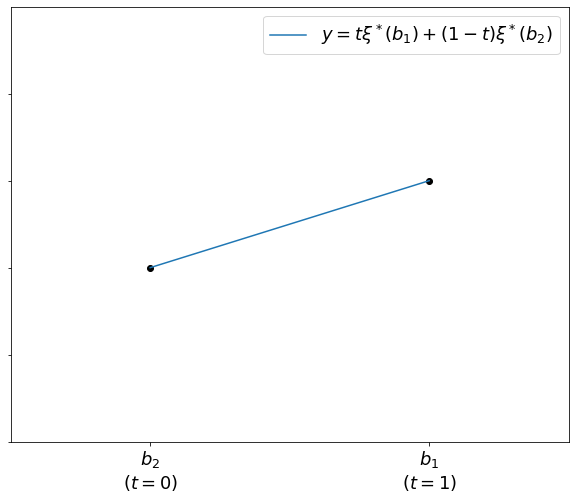

In [3]:
x, y = [1, 2],[2,3]
x2, y2 = [1, 1.3, 2], [2, 3.1, 3]

plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(10,8),facecolor='white')
plt.plot(x, y, label=r'$y = t \xi^*\left(b_1\right)+ (1-t) \xi^*\left(b_2\right)$')
plt.scatter(x, y, color="black")

plt.xticks(x, labels=["$b_2$\n$(t=0)$", "$b_1$\n$(t=1)$"])
plt.yticks(np.arange(5), labels=[])
plt.xlim(0.5, 2.5)
plt.ylim(0,5)
plt.legend()

**Case 2:** $b_1$ and $b_2$ yield different optimal bases.

Referring again to sensitivity analysis, there will be a value (or several) of $t \in [0,1]$ where a change of basis (pivot) is required. Since the basis changes, so do the cost coefficients in $c_\mathcal{B}$, and the objective function will not increase or decrease at the same rate.

The graph of $\xi^*$ now looks like this (in orange), and we can compare it to the line given by a simple linear interpolation of the optimal objective values associated with $b_1$ and $b_2$. 

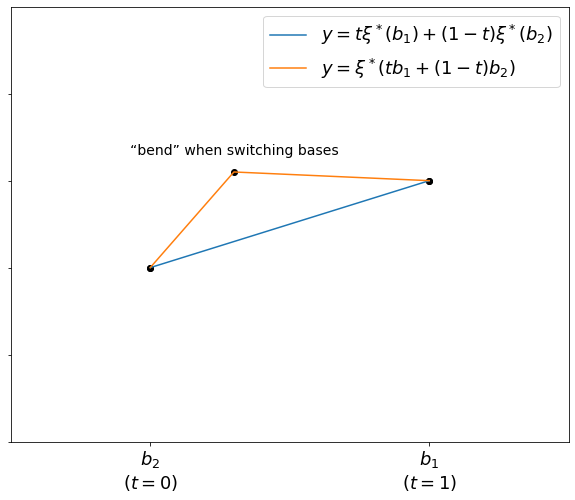

In [5]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(10,8),facecolor='white')
plt.plot(x, y, label=r'$y = t \xi^*\left(b_1\right)+ (1-t) \xi^*\left(b_2\right)$')
plt.scatter(x, y, color="black")

plt.plot(x2, y2, label=r'$y= \xi^*\left(t b_1 + (1-t) b_2 \right)$')
plt.scatter(x2, y2, color="black")
plt.annotate('“bend” when switching bases', [1.3, 3.3], ha="center", size=14)

plt.xticks(x, labels=["$b_2$\n$(t=0)$", "$b_1$\n$(t=1)$"])
plt.yticks(np.arange(5), labels=[])
plt.xlim(0.5, 2.5)
plt.ylim(0,5)
plt.legend()

The problem asks us to show that

$$\text{orange line} \geq \text{blue line}$$

for all pairs of $b_i$. This is true in the graph above, but to complete the proof, we need to show that the orange line will not have its &ldquo;bend&rdquo; on the other side of the blue line, violating the inequality. 

<span id="simpler"><strong>A simpler approach</strong></span> was suggested on <a href="https://math.stackexchange.com/questions/3569984/proof-that-xib-is-concave-for-arbitrary-b-in-a-linear-program">Stack Exchange</a>. The proof below stands on its own:

For $b_1$, the simplex method guarantees an optimal primal solution $x_1$ and optimal dual solution $y_1$ with corresponding costs $c^T x_1 = b_1^T y_1$. Perturb $b_1$ to $t b_1 + (1-t) b_2$. Then $y_1$ remains dual feasible, and $(t b_1 + (1-t) b_2)^T y_1$ provides a lower bound for the optimal objective value of this new problem. 

That is, 

$$\begin{align}
\xi^*\left(t b_1 + (1-t) b_2\right)  \geq &~(t b_1 + (1-t) b_2)^T y_1 & \text{because $y_1$ remains dual feasible} \\
& = t b_1^T y_1 + (1-t) b_2^T y_1 \\
 \geq &~t b_1^T y_1 + (1-t) b_2^T y_2 & \text{because $b_2^T y_1 \geq b_2^T y_2$} \\
& = t \xi^*(b_1) + (1-t) \xi^*(b_2)
\end{align}$$

$y_2$ denotes the optimal solution to the problem where $b = b_2$, and we know $b_2^T y_1 \geq b_2^T y_2$ because it is a minimization problem.

This is the claim made in $(♥)$.

In [289]:
mpl.rcParams.update(mpl.rcParamsDefault)

## Performance of the simplex method

Reference: Robert J. Vanderbei, *Linear Programming: Foundations and Extensions,* ch. 12.

I replicate the performance test of the simplex method given in section 6, which compares the size ($m+n$) of a linear program to the number of iterations of the simplex method used to reach an optimal solution.

Here I use Scipy&rsquo;s implementation of the simplex method rather than my own, as the former is faster.

In [309]:
# Yields a random linear program of chosen size and sparsity (in A and c)
def rand_LP(m, n, sparsity = 0.5):
    # To guarantee feasibility, ensure that there is a positive x and positive y
    x = np.random.rand(n) + 0.1
    y = np.random.rand(m) + 0.1
    A = np.round( np.random.normal(size=(m,n)) * (np.random.rand(m,n)>=sparsity) , decimals=1)
    # such that A x is less than b and A.T y is less than c
    b = np.round(  A @ x + np.random.rand(m) + 0.1, decimals=2)
    c = np.round(  y @ A - np.random.rand(n) - 0.1, decimals=2)
    return c, A, b

# Evaluates a bunch of linear programs with m and n chosen from a geometric (I think) distribution
# that favors large sizes
def tester(size):
    mn = []
    nit = []
    for i in range(size):
        # Random n and m between 10 and 500
        m = int(10**(1.7*np.random.rand() +1))
        n = int(10**(1.7*np.random.rand() +1))
        # Random LP of that size
        c, A, b = rand_LP(m,n)
        # Make sure that A isn't zeros
        if not np.all(A==0):
            mn.append(m+n)
            nit.append(optimize.linprog(c = c, A_ub = A, b_ub= b, options={'tol': 1e-5}).nit)
    return np.array(mn), np.array(nit)

This is the money cell; it takes a long time to run.

In [318]:
np.random.seed(670)
%time x, y = tester(120)

Wall time: 2min 11s


Fit a power model to the data. I tweak Vanderbei&rsquo;s $y = 2^\alpha(m+n)^\beta$ to $y = a (m+n)^b - 1$. Shifting the $y$-intercept avoids $\log 0$ errors in the occasional case that requires 0 iterations.

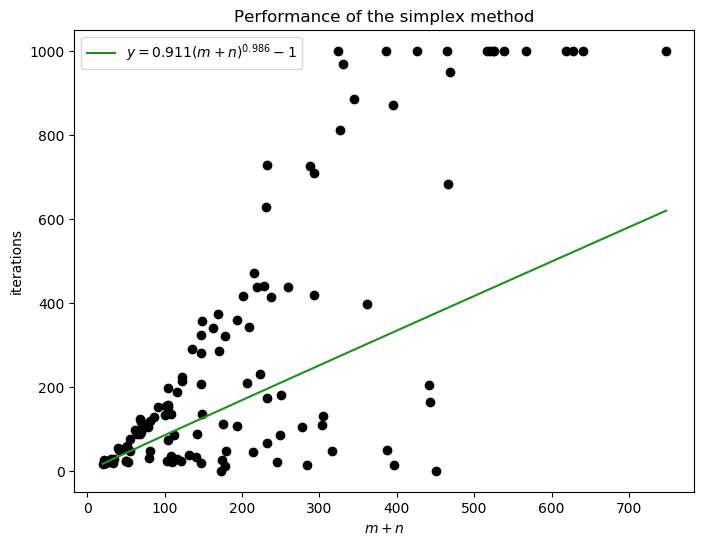

In [319]:
ln_a, b = np.linalg.lstsq(np.stack([np.ones_like(x), np.log(x)]).T, np.log(y+1), rcond=None)[0]
a = np.exp(ln_a)

x_plot = np.linspace(x.min(), x.max(), 101)
y_plot = (a * x_plot**b -1)

plt.figure(figsize=(8, 6))
plt.scatter(x,y, color='black')
plt.plot(x_plot, y_plot,
         label=r'$y = {} (m+n)^{{{}}} - 1$'.format(np.round(a, decimals=3), np.round(b, decimals=3)),
        color = 'forestgreen')
plt.xlabel(r'$m+n$')
plt.ylabel('iterations')
plt.title('Performance of the simplex method')
plt.legend()

#plt.yscale('log')
#plt.xscale('log')

My data don&rsquo;t look nearly as clean as Vanderbei&rsquo;s, even if you turn on the log scaling. 

## Sales force planning problem

Reference: Robert J. Vanderbei, *Linear Programming: Foundations and Extensions,* ch. 12.

Problem 12.7: 

> A distributor of office equipment finds that the business has seasonal peaks and valleys. The company uses two types of sales persons: (a) regular employees who are employed year-round and cost the company \\$17.50/h (fully loaded for benefits and taxes) and (b) temporary employees supplied by an outside agency at a cost of \\$25/h. Projections for the number of hours of labor by month for the following year are shown in Table 12.2. Let $a_i$ denote the number of hours of labor needed for month $i$ and let $x$ denote the number of hours per month of labor that will be handled by regular employees. To minimize total labor costs, one needs to solve the following optimization problem:
>
>$$\text{minimize}~\sum_i\bigl(25\max(a_i − x,0) + 17.50x\bigr)$$
><ul style="list-style-type: lower-alpha;"><li>Show how to reformulate this problem as a linear programming problem.</li><li>Solve the problem for the specific data [given below].</li><li>Use calculus to find a formula giving the optimal value for $x$.</li></ul>


#### Part (a)

Let $w_i = \max(a_i - x)$, the number of extra workers hired in each month. Then the objective function is

$$ \zeta = \sum_{i=1}^n (17.50 x + 25 w_i ) = 17.50 n (x) + \sum_{i=1}^n 25(w_i)$$

and the problem can be rewritten as

$$\begin{align}
&\text{minimize} & \zeta & =  17.50 n (x) + \sum_{i=1}^n 25(w_i) \\
&\text{subject to} & x + w_1 & \geq  a_1 \\
&& x+ w_2 & \geq  a_2 \\
&&   & ~~\vdots \\
&& x+ w_n & \geq  a_n\\
&& x, w & \geq  0
\end{align}$$

which is basically standard form. 

#### Part (b)
For the sample data, $n=12$, and the optimal solution has $x = 340$. 

In [321]:
c = np.array([17.5*12, # x
              25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25]) # w_i
A_lb = np.hstack([np.ones((1,12)).T, np.eye(12)])

# Sample data (monthly demand in hours)
b_lb = np.array([390, 420, 340, 320, 310, 590, 340, 580, 550, 360, 420, 600])

optimize.linprog(c,  A_ub = -A_lb, b_ub = -b_lb)

     con: array([], dtype=float64)
     fun: 101150.0
 message: 'Optimization terminated successfully.'
     nit: 19
   slack: array([ 0.,  0.,  0., 20., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])
  status: 0
 success: True
       x: array([340.,  50.,  80.,   0.,   0.,   0., 250.,   0., 240., 210.,  20.,
        80., 260.])

#### Part (c)
$\zeta$ is differentiable everywhere except where $x=a_i$, but we disregard these marginal cases because this is linear programming.

Then the minimum occurs where $\frac{d}{dx} \zeta = 0$. Note that 

$$\frac{d}{dx} w_i = \frac{d}{dx} (a_i -x)^+ = 
\begin{cases} -1,& x \lt a_i \\
~0,& x \gt a_i \end{cases}$$

so 

$$\begin{align}
\frac{d}{dx} \zeta
& = 17.5 n - 25 \sum \frac{d}{dx} w_i  \\
& = 17.5 n - 25 M  \\
\end{align}$$

where $M$ is the number of $i \in \{1, 2, \dots, n\}$ for which $x \lt a_i$&mdash;that is, the number of months in which extra workers are hired.

This derivative is zero when $x$ is chosen so that $25 M = 17.5 n$.

## Dijkstra&rsquo;s Algorithm

Reference: Robert J. Vanderbei, *Linear Programming: Foundations and Extensions,* ch. 14.

I code a simple implementation of Dijkstra&rsquo;s shortest-path algorithm and use it to find the shortest routes to Naju from various cities in the Jeonnam region.

We start by inputting the problem data and visualizing the graph (map) using the Networkx library.

In [20]:
# Indice the cities
cities = 'Hampyeong Gwangju Muan Naju Hwasun Mokpo Yeongam Jangheung Boseong Haenam'.split()
cities = dict(zip(range(len(cities)), cities))

# Roads in an array
roads = np.array([[0, 2, 19.6],
         [1, 3, 16.4],
         [2, 3, 32.6],
         [2, 5, 18.3],
         [3, 4, 32.0],
         [3, 5, 37.9],
         [3, 7, 44.8],
         [4, 7, 56.8],
         [4, 8, 33.8],
         [5, 6, 27.1],
         [5, 9, 30.7],
         [6, 7, 36.0],
         [6, 9, 43.7],
         [7, 8, 23.2],
         [7, 9, 54.1]])

G = nx.Graph()
for a, b, c in roads:
    G.add_edge(int(a), int(b), length=c)

# Node positions
node_pos = np.array([[1, 5],
       [3, 5],
       [0, 4],
       [2, 4],
       [4, 4],
       [0, 3],
       [1.2, 3.2],
       [2.5, 2.5],
       [4, 3],
       [1, 2]])

node_pos_dict = dict(zip(range(len(cities)),
     node_pos))

# Label positions (just offset from the nodes)
label_pos_dict = dict(zip(range(len(cities)), np.add([0, 0.15], node_pos)))

edge_labels = nx.get_edge_attributes(G,'length')

{(0, 2): Text(0.5, 4.5, '19.6'),
 (2, 3): Text(1.0, 4.0, '32.6'),
 (2, 5): Text(0.0, 3.5, '18.3'),
 (1, 3): Text(2.5, 4.5, '16.4'),
 (3, 4): Text(3.0, 4.0, '32.0'),
 (3, 5): Text(1.0, 3.5, '37.9'),
 (3, 7): Text(2.25, 3.25, '44.8'),
 (5, 6): Text(0.6, 3.1, '27.1'),
 (5, 9): Text(0.5, 2.5, '30.7'),
 (4, 7): Text(3.25, 3.25, '56.8'),
 (4, 8): Text(4.0, 3.5, '33.8'),
 (7, 6): Text(1.85, 2.85, '36.0'),
 (7, 8): Text(3.25, 2.75, '23.2'),
 (7, 9): Text(1.75, 2.25, '54.1'),
 (6, 9): Text(1.1, 2.6, '43.7')}

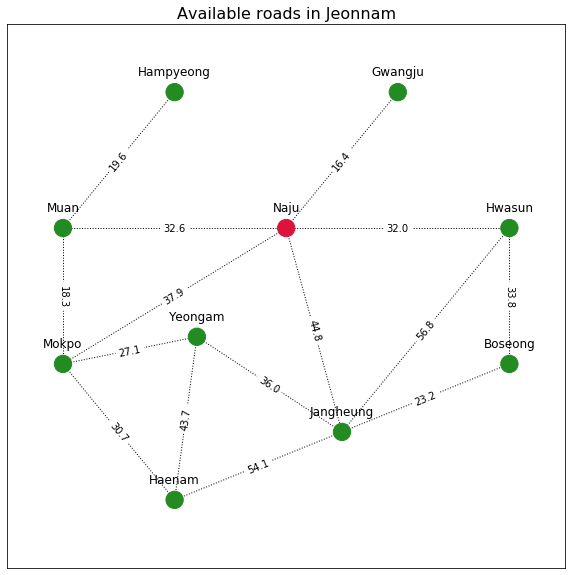

In [21]:
plt.figure(figsize=(10,10), facecolor="white")
plt.xlim(-0.5,4.5)
plt.ylim(1.5,5.5)
plt.title('Available roads in Jeonnam', size=16)

nx.draw_networkx_nodes(G, node_pos_dict, node_color = ['forestgreen',
 'forestgreen',
 'forestgreen',
 'crimson',
 'forestgreen',
 'forestgreen',
 'forestgreen',
 'forestgreen',
 'forestgreen',
 'forestgreen'])
nx.draw_networkx_labels(G, label_pos_dict, cities)
nx.draw_networkx_edges(G, node_pos_dict, style='dotted')
nx.draw_networkx_edge_labels(G, node_pos_dict, edge_labels=edge_labels)

Of the available roads shown above, which ones offer the shortest routes to and from Naju? We are looking for an optimal spanning tree, given Naju as a demand node and the others as supply nodes (or vice-versa). This is the problem solved by Dijkstra&rsquo;s algorithm.

In [4]:
def dijkstra(roads, r):
    n = int(roads[:,1].max()) +1 # number of nodes
        
    F = []
    h = np.zeros(n)
    h[r] = r
    v = np.array([np.inf]*n)
    v[r] = 0
    nit = 0
    
    while len(F) < n:
        F_mask = np.zeros(n)
        for i in F:
            F_mask[i] = 1
        j = np.argmin(np.ma.masked_array(v, F_mask))
        F.append(j)
        
        # Edges that link to j
        edges_to_check = roads[(roads[:,:2]==j).any(axis=1)]
        
        for a, b, c in edges_to_check:
            # Check against a and b because you can travel either way
            if c + v[j] < v[int(a)]:
                v[int(a)] = c + v[j]
                h[int(a)] = j
                
            if c + v[j] < v[int(b)]:
                v[int(b)] = c + v[j]
                h[int(b)] = j
        nit += 1
        
    return F, h, v

F, h, v = dijkstra(roads, 3)
F, h, v

([3, 1, 4, 2, 5, 7, 0, 6, 8, 9],
 array([2., 3., 3., 3., 3., 3., 5., 3., 4., 5.]),
 array([52.2, 16.4, 32.6,  0. , 32. , 37.9, 65. , 44.8, 65.8, 68.6]))

In the output above:
- `F` is a list of visited nodes (the algorithm visits every node, but the order is interesting).
- `h` indicates which node should be visited next along the optimal path. For example, if start from Haenam (at index 9) we see that `h[9]` is 5, so we should go to Mokpo next. `h` thus describes the optimal spanning tree for this problem.
- `v` contains the distance from each node to Naju, i.e. the sum of the lengths of the roads in the optimal path.

In [22]:
# optimal spanning tree
ost = np.stack([h, np.arange(len(h))]).T

# delete root node, which points to itself
ost = np.delete(ost, 3, axis=0)

# sort it so the edge directions match the original graph
ost.sort(axis=1)
ost

# Create an optimality attr on G's edges
nx.set_edge_attributes(G, False, 'optimal')

# Indicate which edges were optimal
for i in ost:
    G.edges[i]['optimal']=True

# List of optimal and inoptimal nodes for plotting convenience
optimal_nodes = []
inopt_nodes = []

for a, b in nx.get_edge_attributes(G, 'optimal').items():
    if b: optimal_nodes.append(a)
    else: inopt_nodes.append(a)

{(0, 2): Text(0.5, 4.5, '19.6'),
 (2, 3): Text(1.0, 4.0, '32.6'),
 (2, 5): Text(0.0, 3.5, '18.3'),
 (1, 3): Text(2.5, 4.5, '16.4'),
 (3, 4): Text(3.0, 4.0, '32.0'),
 (3, 5): Text(1.0, 3.5, '37.9'),
 (3, 7): Text(2.25, 3.25, '44.8'),
 (5, 6): Text(0.6, 3.1, '27.1'),
 (5, 9): Text(0.5, 2.5, '30.7'),
 (4, 7): Text(3.25, 3.25, '56.8'),
 (4, 8): Text(4.0, 3.5, '33.8'),
 (7, 6): Text(1.85, 2.85, '36.0'),
 (7, 8): Text(3.25, 2.75, '23.2'),
 (7, 9): Text(1.75, 2.25, '54.1'),
 (6, 9): Text(1.1, 2.6, '43.7')}

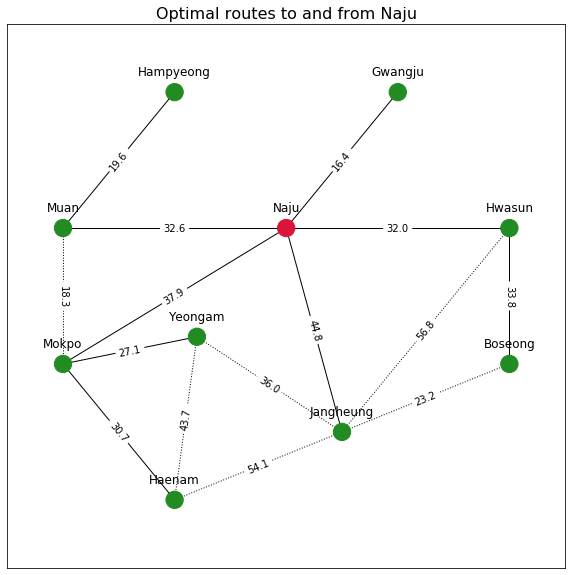

In [24]:
plt.figure(figsize=(10,10), facecolor="white")
plt.xlim(-0.5,4.5)
plt.ylim(1.5,5.5)
plt.title('Optimal routes to and from Naju', size=16)

nx.draw_networkx_nodes(G, node_pos_dict, node_color = ['forestgreen',
 'forestgreen',
 'forestgreen',
 'crimson',
 'forestgreen',
 'forestgreen',
 'forestgreen',
 'forestgreen',
 'forestgreen',
 'forestgreen'])

# To show the distances
# nx.draw_networkx_labels(G, node_pos_dict, {a:b for a, b in enumerate(v)})

nx.draw_networkx_labels(G, label_pos_dict, cities)
nx.draw_networkx_edges(G, node_pos_dict, edgelist=inopt_nodes, style='dotted')
nx.draw_networkx_edges(G, node_pos_dict, edgelist=optimal_nodes, style='solid')
nx.draw_networkx_edge_labels(G, node_pos_dict, edge_labels=edge_labels)

The above plot indicates the optimal routes in solid lines.

## Currency arbitrage

Reference: Robert J. Vanderbei, *Linear Programming: Foundations and Extensions,* ch. 15.

Given a table of exchange rates, can we identify a cycle of trades that will allow us to turn $1 USD into a greater amount (arbitrage)? This can be modeled as a network flow problem, as suggested in problem 15.9.

In the implementation, we must place an upper bound on the profit (here $t$) because if, for a given currency exchange matrix, an arbitrage opportunity does exist, then the expected profit is infinite, since you can cycle endlessly through any profitable chain of currencies.

The goal is to choose $t$ such that the algorithm outputs a legible cycle. Sometimes a lower choice for $t$ allows the algorithm to terminate more quickly, but if $t$ is too low, you run into rounding errors.

A more thorough option is to choose a relatively high $t$-value and then run a path-finding algorithm on the output to find the shortest cycle. 

My code defaults to $t = 0.1$, corresponding to a 10-percent profit.

In [13]:
def curr_arb(r, h=0, t=0.1): 
    # r is the currency exchange matrix
    # h is the home currency
    # t is the upper bound on profit
    
    currencies = np.arange(r.shape[0])
    assert r.shape[0]==r.shape[1] and len(r.shape)==2, "Currency matrix isn't square"
    
    # Constraints
    A_eq = []

    for j in currencies: #[currencies!=h]:
        dummy = np.zeros_like(r)
        dummy[j] = -1 #-r[j] # Node outflows
        if j!=h: dummy[:,j] = r[:,j] # Node inflows (ignored in home currency)
        dummy[j,j] = 0
        A_eq.append(dummy.flatten())


    # Nodes aren't connected to themselves, so force all x_jj = 0
    A_eq.append(np.eye(r.shape[0]).flatten())

    A_eq = np.array(A_eq)
    b_eq = np.zeros(A_eq.shape[0])
    b_eq[h] = -1 # Only one dollar can leave home currency
    
    # Objective function
    c = np.zeros_like(r)
    c[h] = -1 #r[h]
    c[:,h] = r[:,h]
    c[h,h]=0

    c= c.flatten()
    out = optimize.linprog(c = -c,
                 A_eq = A_eq,
                 b_eq = b_eq,
                 A_ub = c.reshape(1,-1),
                 b_ub = t,
                 method = 'simplex')
    print(out)
    return out.x.reshape(r.shape)

Here is some sample currency data from the textbook. Vanderbei indicates that USD&rarr;Yen&rarr;Mark&rarr;USD is a possible arbitrage cycle. Each cell indicates the price of one unit of the column currency in units of the row currency.

In [14]:
curr_names = 'USD Yen Mark Franc'.split()
r = np.array([float(i) for i in '1 111.52 1.4987 5.0852 .008966 1 .013493 .045593 .6659 73.964 1 3.3823 .1966 21.933 .29507 1'.split()]).reshape(4, 4)
r

array([[1.0000e+00, 1.1152e+02, 1.4987e+00, 5.0852e+00],
       [8.9660e-03, 1.0000e+00, 1.3493e-02, 4.5593e-02],
       [6.6590e-01, 7.3964e+01, 1.0000e+00, 3.3823e+00],
       [1.9660e-01, 2.1933e+01, 2.9507e-01, 1.0000e+00]])

In [15]:
x = curr_arb(r, 0, 1)
x

     con: array([ 1.45883305e-13, -1.45519152e-11,  1.09245946e-13,  0.00000000e+00,
        0.00000000e+00])
     fun: -0.999999999999839
 message: 'Optimization terminated successfully.'
     nit: 12
   slack: array([1.60982339e-13])
  status: 0
 success: True
       x: array([0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.15381729e+05, 0.00000000e+00,
       3.00345397e+00, 0.00000000e+00, 0.00000000e+00, 1.55384222e+03,
       0.00000000e+00, 5.25556053e+03, 0.00000000e+00, 0.00000000e+00])


array([[0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.15381729e+05, 0.00000000e+00],
       [3.00345397e+00, 0.00000000e+00, 0.00000000e+00, 1.55384222e+03],
       [0.00000000e+00, 5.25556053e+03, 0.00000000e+00, 0.00000000e+00]])

These results offer a great demonstration of cycling. The resultant graph, shown below, contains the long cycle of USD&rarr;Yen&rarr;Mark&rarr;Franc&rarr;Yen&rarr;Mark&rarr;USD, as well as the shorter cycle USD&rarr;Yen&rarr;Mark&rarr;USD mentioned in the textbook. You can proceed around the Yen&rarr;Mark&rarr;Franc&rarr;Yen cycle as many times as you wish, assuming the rates remain static.

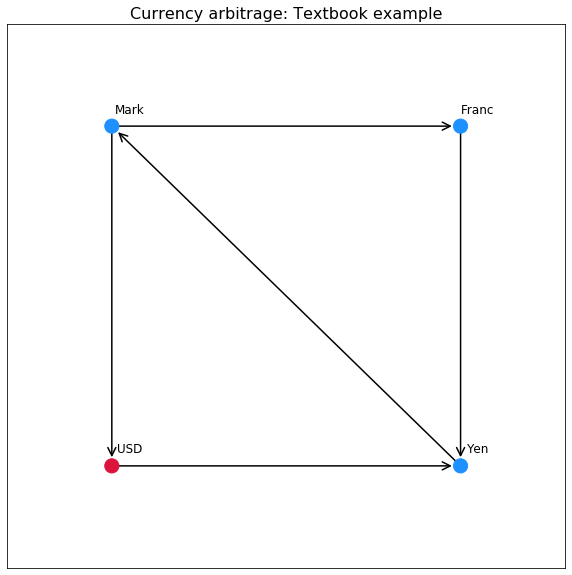

In [16]:
G = nx.from_numpy_array(x, create_using=nx.DiGraph)

node_locs = np.stack(np.meshgrid(np.arange(2),np.arange(2)), axis=2).reshape(-1, 2)

node_locs_dict = {a: node_locs[a] for a in range(4)} 
label_locs_dict = {a: node_locs[a]+[.05] for a in range(4)} 


plt.figure(figsize=(10,10), facecolor='white')
plt.title('Currency arbitrage: Textbook example', size=16)

nx.draw_networkx_nodes(G, node_locs_dict, node_size=200,
                       node_color = ['crimson','dodgerblue','dodgerblue','dodgerblue'])
nx.draw_networkx_edges(G, node_locs_dict, width=1.5, arrowsize=20, arrowstyle='->')
nx.draw_networkx_labels(G, label_locs_dict, dict(zip(range(4), curr_names)))

plt.xlim(-0.3,1.3)
plt.ylim(-0.3,1.3)

Let&rsquo;s see what happens if we use current data with more currencies (<a href="https://www.exchangerates.org.uk/currency/currency-exchange-rates-table.html">data source</a>).

In [8]:
curr_names = "GBP EUR USD JPY CHF CAD AUD NZD RUB ZAR MXN AED".split()

r = np.array([float(i) for i in """
1	1.0597	1.1496	125.4346	1.1179	1.6705	2.017	2.0399	91.7542	20.012	28.1668	4.219
0.9437	1	1.0849	118.3707	1.055	1.5764	1.9034	1.925	86.587	18.885	26.5805	3.9814
0.8699	0.9218	1	109.1125	0.9725	1.4531	1.7546	1.7744	79.8147	17.4079	24.5016	3.67
0.008	0.0084	0.0092	1	0.0089	0.0133	0.0161	0.0163	0.7315	0.1595	0.2246	0.0336
0.8945	0.9479	1.0283	112.2026	1	1.4942	1.8042	1.8247	82.075	17.9009	25.1955	3.7739
0.5986	0.6344	0.6882	75.0897	0.6692	1	1.2075	1.2212	54.9274	11.9799	16.8616	2.5256
0.4958	0.5254	0.5699	62.1881	0.5542	0.8282	1	1.0113	45.49	9.9216	13.9646	2.0917
0.4902	0.5195	0.5636	61.4909	0.548	0.8189	0.9888	1	44.98	9.8103	13.808	2.0682
0.0109	0.0115	0.0125	1.3671	0.0122	0.0182	0.022	0.0222	1	0.2181	0.307	0.046
0.05	0.053	0.0574	6.268	0.0559	0.0835	0.1008	0.1019	4.585	1	1.4075	0.2108
0.0355	0.0376	0.0408	4.4533	0.0397	0.0593	0.0716	0.0724	3.2575	0.7105	1	0.1498
0.237	0.2512	0.2725	29.7309	0.265	0.3959	0.4781	0.4835	21.7478	4.7433	6.6762	1
""".split()]).reshape(12,12)

h = 11 # UAE Dirham

In [9]:
x = curr_arb(r, h, .001)

     con: array([-2.22044605e-16,  4.44089210e-16,  0.00000000e+00,  0.00000000e+00,
       -4.44089210e-16,  8.88178420e-16, -4.44089210e-16,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00])
     fun: -0.0009999999999983356
 message: 'Optimization terminated successfully.'
     nit: 15
   slack: array([1.66446718e-15])
  status: 0
 success: True
       x: array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.70625749, 0.        , 0.        ,
       0.        , 0.23726001, 2.05946541, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 2.23409877, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.    

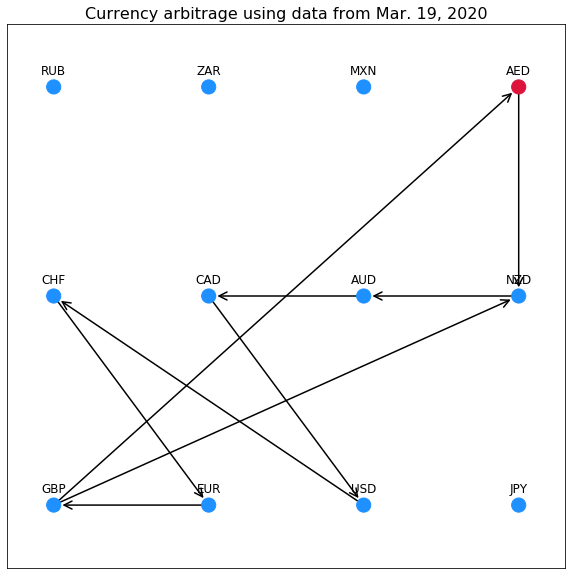

In [11]:
G = nx.from_numpy_array(x, create_using=nx.DiGraph)

node_locs = np.stack(np.meshgrid(np.arange(4),np.arange(3)), axis=2).reshape(-1, 2)

node_locs_dict = {a: node_locs[a] for a in range(12)} 
label_locs_dict = {a: node_locs[a]+[0,.08] for a in range(12)} 

colors = ['dodgerblue']*12
colors[h] = 'crimson'

plt.figure(figsize=(10,10), facecolor='white')
plt.title('Currency arbitrage using data from Mar. 19, 2020', size=16)

nx.draw_networkx_nodes(G, node_locs_dict, node_size=200,
                       node_color = colors)
nx.draw_networkx_edges(G, node_locs_dict, width=1.5, arrowsize=20, arrowstyle='->')
nx.draw_networkx_labels(G, label_locs_dict, dict(zip(range(12), curr_names)))

plt.xlim(-0.3,3.3)
plt.ylim(-0.3,2.3)

Using this quite complicated cycle, arbitrage is possible tonight in AED (the United Arab Emirates Dirham). I think the dual slacks indicate the profit made at each node you stop at. 

Why doesn&rsquo;t this work in real life? Exchange rates change in real time, so if an arbitrage loop appears, lots of people will start buying the currencies in the loop, driving their prices up and negating the opportunity for arbitrage. High-frequency traders are able to do this kind of thing using automated systems, but if you can afford such a system, you would be better off investing the money in mutual funds.

## Structural optimization

Reference: Robert J. Vanderbei, *Linear Programming: Foundations and Extensions,* ch. 16.

I replicate figs. 16.4&ndash;6, in which we determine the minimum-weight structure needed to support a fixed load suspended at some distance from a row of anchor joints. The optimal solution yields a leaf shape. 

In [17]:
# Set up the grid of nodes
nodes_x, nodes_y = np.meshgrid(np.arange(0,50), np.arange(0,40))
node_locs = np.array(list(zip(nodes_x.flatten(), nodes_y.flatten())))
node_locs = {str(t): t for i, t in enumerate(node_locs)}

node_numbers = {a:b for b, a in enumerate(node_locs)}

# A helper function; I ended up working around using it because it is slow.
# What is the name of the node at (x, y)?
def nidfl(xy): # node id from location
    for i in node_locs:
        if np.array_equal(xy, node_locs[i]): return i

In [18]:
# Classify each node by type: we have seven anchor nodes and one with an external load
node_types = {i: 'gray' for i in node_locs}

for i in node_locs:
    
    # Anchor nodes
    if node_locs[i][0] == 0 and node_locs[i][1] in range(20,27):
        node_types[i] = 'black'
        
    # External load
    if np.array_equal(node_locs[i], [49,23]):
        node_types[i] = 'cornflowerblue'

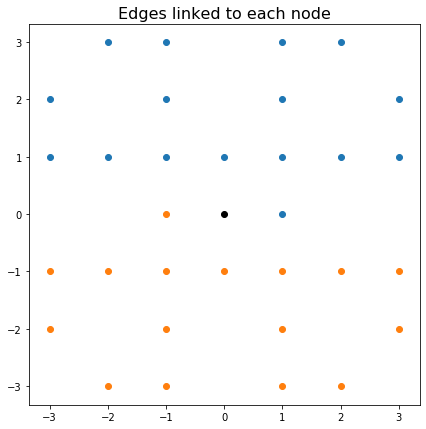

In [19]:
dummy = np.array([[1,0],[1,1],[1,2],[1,3],[2,1],[2,3],[3,1],[3,2]])
r = np.array([[0,1],[-1,0]])

# Basis for edges available at each node
# Contains only half of those available to avoid redundancy 
edges_rel = np.vstack([dummy,dummy @ r])

edges_rel_l = np.linalg.norm(edges_rel, axis=1)
edges_rel_u = edges_rel / edges_rel_l.reshape(16,1)

plt.figure(figsize=(7,7))
plt.title('Edges linked to each node', size=16)
plt.scatter(*edges_rel.T)
plt.scatter(*-edges_rel.T)
plt.scatter(0,0, color='black')

In [20]:
edges = []
edges_l = []
edges_u = []
b = []

# Determine the edges connected to each node and their lengths

for i in node_locs: 
    w = node_locs[i] + edges_rel
    for d, j in enumerate(w): 
        if str(j) in node_locs:
            # Need to derive node-incidence matrix from this
            edges.append([i,str(j)])
            edges_l.append(edges_rel_l[d])
            edges_u.append(edges_rel_u[d])
    if node_types[i]=='black': b.append([np.inf, np.inf]) # Anchored nodes can have arbitrary stress
    if node_types[i]=='cornflowerblue': b.append([0,-10000]) # Blue node bears ext load
    if node_types[i]=='gray': b.append([0,0]) # Others should balance to 0

edges = np.array(edges)
edges_l = np.array(edges_l)
edges_u = np.array(edges_u)
n_edges = edges.shape[0]

In [21]:
b = np.array(b).flatten()
c = np.hstack([edges_l]*2)
A = np.zeros((b.size, edges_u.size))

for i, e in enumerate(edges):
    j, k = e
    j, k = node_numbers[j], node_numbers[k]
    
    A[[2*j, 2*j+1],i] = edges_u[i]
    A[[2*j, 2*j+1],i+n_edges] = -edges_u[i]
    
    A[[2*k, 2*k+1],i] = -edges_u[i]
    A[[2*k, 2*k+1],i+n_edges] = edges_u[i]

# Delete anchor constraints
A = A[b!=np.inf]
b = b[b!=np.inf]

In [22]:
# Have to use interior point; simplex phase I takes forever
%time out = optimize.linprog(c, A_eq = A, b_eq = -b, method='interior-point')
out

Wall time: 24min 42s


     con: array([-1.54429988e-18, -9.22736517e-19,  2.95971841e-18, ...,
       -1.05494579e-17, -7.46818362e-18, -1.22568248e-17])
     fun: 3286689.208864934
 message: 'Optimization terminated successfully.'
     nit: 33
   slack: array([], dtype=float64)
  status: 0
 success: True
       x: array([5.69282638e-07, 4.03455708e-07, 2.57579073e-07, ...,
       5.68901116e-07, 5.74243770e-07, 5.70760881e-07])

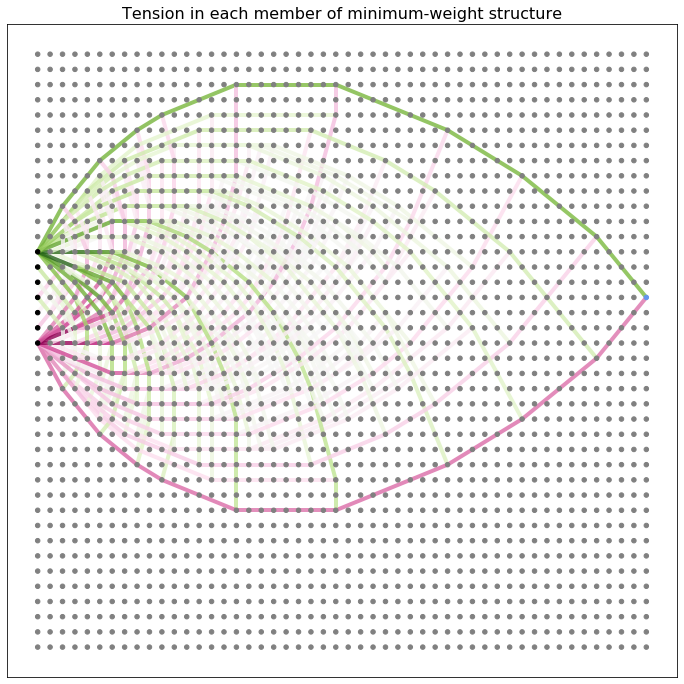

In [35]:
# Tension in each member
# Subtract the negative part from the positive part
tension = out.x[:n_edges] - out.x[n_edges:]

# Only plot members with significant tension
# (otherwise you get white lines from cmap)
edges_plot = edges[np.abs(tension) > 1e-2]
tension_plot = tension[np.abs(tension) > 1e-2] / np.abs(tension).max()

tension_plot = np.sign(tension_plot) * np.sqrt(np.abs(tension_plot))

G = nx.Graph()
G.add_nodes_from(node_locs.keys())
G.add_edges_from(edges_plot)

plt.figure(figsize=(12,12),facecolor="white")
plt.title('Tension in each member of minimum-weight structure', size=16)
nx.draw_networkx_nodes(G, pos = node_locs, node_size=20, node_color=node_types.values())
nx.draw_networkx_edges(G, pos = node_locs, alpha=.8, edge_color= tension_plot, edge_cmap=plt.cm.PiYG, width=4)

## Application of the Woodbury matrix identity

Reference: Robert J. Vanderbei, *Linear Programming: Foundations and Extensions,* ch. 19.

Exercise 19.1 asks us to show that, assuming these inverses exist,

$$\left(E^{-1} + A D A^{T}\right)^{-1} = E - E A \left(D^{-1} + A^{T} E A\right)^{-1} A^{T} E$$

Multiplying the inverse of the left side by the right side, we have:

$$\begin{align}
\left[E^{-1} + A D A^{T}\right]\left[ E - E A \left(D^{-1} + A^{T} E A\right)^{-1}A^{T}E \right] 
& = E^{-1}E+ ADA^T E - \left[\left(E^{-1} + ADA^T\right) EA \left(D^{-1} + A^T EA \right)^{-1} A^TE \right] \\
& = I + ADA^TE - \left[\left(I + ADA^TE\right) A \left(D^{-1} + A^T EA \right)^{-1} A^TE \right]\\
& = I + ADA^TE - \left[\left(A + ADA^TEA\right)  \left(D^{-1} + A^T EA \right)^{-1} A^TE \right]\\
& = I + ADA^TE - \left[AD\left( D^{-1} + A^TEA\right) \left(D^{-1} + A^T EA \right)^{-1} A^TE \right]\\
& = I + ADA^TE - ADA^TE \\
& = I\\
\end{align}$$

This shows that $\left(E^{-1} + A D A^{T}\right)$ is a left-inverse for $ E - E A \left(D^{-1} + A^{T} E A\right)^{-1} A^{T} E$. Similar operations show it is a right-inverse, too. 

This result follows from the <a href="https://en.wikipedia.org/wiki/Woodbury_matrix_identity">Woodbury matrix identity</a>. 


In [34]:
!jupyter nbconvert linprog.ipynb

[NbConvertApp] Converting notebook linprog.ipynb to html
[NbConvertApp] Writing 1211298 bytes to linprog.html
